In [1]:
import pandas as pd
import preprocessing as pp
import utils as utils
import numpy as np
from xgboost.sklearn import XGBClassifier
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
import random
seed = 100
np.random.seed(seed)
random.seed(seed)

In [3]:
X, y = utils.importar_datos()

### Modelo 1

- Label encoder para las categóricas
- Hiperparámetros por defecto (se setean dos para que no tire warnings)

Como primera aproximación, se utiliza el preprocesador utilizado en Random Forest (que usa Label Encoding para las variables categóricas) dado que este modelo también se encuentra basado en árboles. Se utilizan los parámetros por deafault.

In [4]:
pipeline = Pipeline([
    ("preprocessor", pp.PreprocessingLE()),
    ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

#### Metricas

In [5]:
utils.metricas_cross_validation(X, y, pipeline)

,Mean,Std,Oof,Max,Min
roc auc,0.839401,0.020735,0.834562,0.875637,0.808953
accuracy,0.812760,0.037182,0.812734,0.880000,0.740000
precision,0.783802,0.059336,0.781362,0.906250,0.675676
recall,0.710526,0.053472,0.710098,0.789474,0.641026
f1 score,0.744343,0.048703,0.744027,0.828571,0.657895


### Modelo 2

- Se utiliza OHE para las categoricas
- Se imputan los missings con la mediana en la edad
- Se separa en dos bins la edad y el precio de ticket (se probó y da mejores resultados que no haciendolo).

In [6]:
pipeline = Pipeline([
    ("preprocessor", pp.PreprocessingXGBoost()),
    ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

#### Metricas

In [7]:
utils.metricas_cross_validation(X, y, pipeline)

,Mean,Std,Oof,Max,Min
roc auc,0.832785,0.033918,0.831967,0.903226,0.788987
accuracy,0.806498,0.027309,0.806492,0.850000,0.760000
precision,0.778990,0.043645,0.777372,0.833333,0.694444
recall,0.694163,0.061951,0.693811,0.815789,0.631579
f1 score,0.732395,0.041243,0.733219,0.794872,0.675676


### Modelo 3

- No se completan los Nans, se deja que XGBoost se encargue de imputarlos

In [8]:
pipeline = Pipeline([
    ("preprocessor", pp.PreprocessingXGBoost2()),
    ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

#### Metricas

In [9]:
utils.metricas_cross_validation(X, y, pipeline)

,Mean,Std,Oof,Max,Min
roc auc,0.833913,0.032412,0.832116,0.889219,0.786807
accuracy,0.811522,0.037675,0.811486,0.890000,0.770000
precision,0.772525,0.046493,0.772727,0.885714,0.735294
recall,0.720310,0.069265,0.719870,0.815789,0.641026
f1 score,0.744631,0.054634,0.745363,0.849315,0.684932


### Modelo 4

- Con el Modelo 1, se corre Grid Search para buscar los mejores hiperparametros

Tuvimos un problema con este GridSearchCV. Por algún motivo, se quedaba estancado un largo rato en cada iteración. Para una grilla de tamaño 1 tardaba más de 10 minutos cuando entrenar el modelo por separado y aplicarle cross_validate tardaba un segundo. 

Por ello se probaron a mano distintas configuraciones y se dejo la que mejor resultado obtuvo

In [10]:
pipeline = Pipeline([
    ("preprocessor", pp.PreprocessingLE()),
    ("model", XGBClassifier(use_label_encoder=False, scale_pos_weight=1, subsample=0.8, colsample_bytree=0.8,
                            objective="binary:logistic", n_estimators=1000, learning_rate=0.01, n_jobs=-1,
                            eval_metric="logloss", min_child_weight=6, max_depth=6, reg_alpha=0.05))
])

In [11]:
utils.metricas_cross_validation(X, y, pipeline)

,Mean,Std,Oof,Max,Min
roc auc,0.866600,0.024098,0.864089,0.893251,0.817487
accuracy,0.827723,0.023254,0.827715,0.870000,0.800000
precision,0.810966,0.039235,0.809524,0.857143,0.750000
recall,0.719889,0.040472,0.719870,0.789474,0.657895
f1 score,0.761952,0.032137,0.762069,0.821918,0.714286


In [12]:
params = {
    'model__learning_rate': [0.05, 0.1, 0.3],
    'model__max_depth': [3, 6, 10],
    'model__n_estimators': [100, 300],
    'model__min_child_weight': [1, 3, 5],
    'model__gamma': [0, 0.1, 0.2],
    'model__eval_metric': ['logloss', 'error']
}

cv = utils.kfold_for_cross_validation()
#gscv = GridSearchCV(pipeline, params, scoring='roc_auc', n_jobs=-1, cv=8, return_train_score=True).fit(X, y)

### Métricas finales

Se eligió el [Modelo 4](#Modelo-4) en base a los resultados obtenidos mediante `cross_validation`.

In [13]:
pipeline = Pipeline([
    ("preprocessor", pp.PreprocessingLE()),
    ("model", XGBClassifier(use_label_encoder=False, scale_pos_weight=1, subsample=0.8, colsample_bytree=0.8,
                            objective="binary:logistic", n_estimators=1000, learning_rate=0.01, n_jobs=-1,
                            eval_metric="logloss", min_child_weight=6, max_depth=6, reg_alpha=0.05))
])

AUC_ROC,Accuracy,Precision,Recall,F1 Score
0.897101,0.867769,0.875000,0.760870,0.813953


Matriz de confusión:


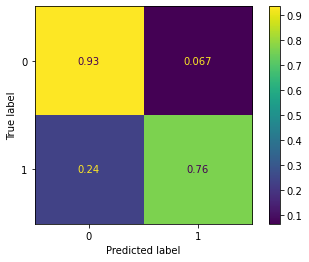

In [14]:
pipeline = utils.entrenar_y_realizar_prediccion_final_con_metricas(X, y, pipeline)

### Predicción HoldOut

In [15]:
utils.predecir_holdout_y_generar_csv(pipeline, 'Predicciones/4-XGBoost.csv')